<h1 align="center" style="color: blue; font-weight: bold;
font-family: 'Fira Code', monospace;">Practical Lab 8 - Fashion MNIST Classification with Dense Neural Networks</h1>

### **Introduction** ###

Fashion-MNIST is a dataset of Zalando's article images consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes. 
Each image is 28 pixels in height and 28 pixels in width, for a total of 784 pixels in total. Each pixel has a single pixel-value associated with it, indicating the lightness or darkness of that pixel, with higher numbers meaning darker. This pixel-value is an integer between 0 and 255.

[Kaggle](https://www.kaggle.com/datasets/zalando-research/fashionmnist)


 **Goal**  - The goal of this notebook is to conduct Exploratory Data Analysis (EDA) on fMNIST, implement and train a fully-connected feedforward neural network using Keras and Tensorflow, evaluate the model's performance using sklearn metrics, and derive clear conclusions.

### **Import Necessary Packages** ###

In [219]:
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import classification_report, precision_score, recall_score, precision_recall_curve
from tensorflow.keras import layers, models


### **Load the Data** ###

In [220]:
# Importing the fMNIST dataset
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

Loading the dataset returns four NumPy arrays:

- The train_images and train_labels arrays are the training set—the data the model uses to learn.
- The model is tested against the test set, the test_images, and test_labels arrays.
- The images are 28x28 NumPy arrays, with pixel values ranging between 0 and 255. The labels are an array of integers, ranging from 0 to 9. These correspond to the class of clothing the image represents:

| Label | Class       |
|-------|-------------|
| 0     | T-shirt/top |
| 1     | Trouser     |
| 2     | Pullover    |
| 3     | Dress       |
| 4     | Coat        |
| 5     | Sandal      |
| 6     | Shirt       |
| 7     | Sneaker     |
| 8     | Bag         |
| 9     | Ankle boot  |


### **Data Exploration** ###

In [221]:
print(f'Image DType: {type(train_images)}')
print(f'Image Element DType: {type(train_images[0,0,0])}')
print(f'Label Element DType: {type(train_labels[0])}')
print('**Shapes:**')
print('Train Data:')
print(f'Images: {train_images.shape}')
print(f'Labels: {train_labels.shape}')
print('Test Data:')  # the text images should be a random sample of the overall test set, and hence should have the same type, shape and image-size as the overall train set
print(f'Images: {test_images.shape}')
print(f'Labels: {test_labels.shape}')
print('Image Data Range:')
print(f'Min: {train_images.min()}')
print(f'Max: {train_images.max()}')

Image DType: <class 'numpy.ndarray'>
Image Element DType: <class 'numpy.uint8'>
Label Element DType: <class 'numpy.uint8'>
**Shapes:**
Train Data:
Images: (60000, 28, 28)
Labels: (60000,)
Test Data:
Images: (10000, 28, 28)
Labels: (10000,)
Image Data Range:
Min: 0
Max: 255


- The data is stored as numpy arrays with image data being of type uint8, indicating pixel values ranging from 0 to 255, and labels as integers. Both train and test sets consist of 28x28 pixel grayscale images, totaling 60,000 and 10,000 samples.
- The pixel values ranging from 0 to 255 indicate grayscale intensity levels. Understanding this range is crucial for preprocessing tasks like normalization, ensuring optimal model convergence during training.

**Understanding the Data**

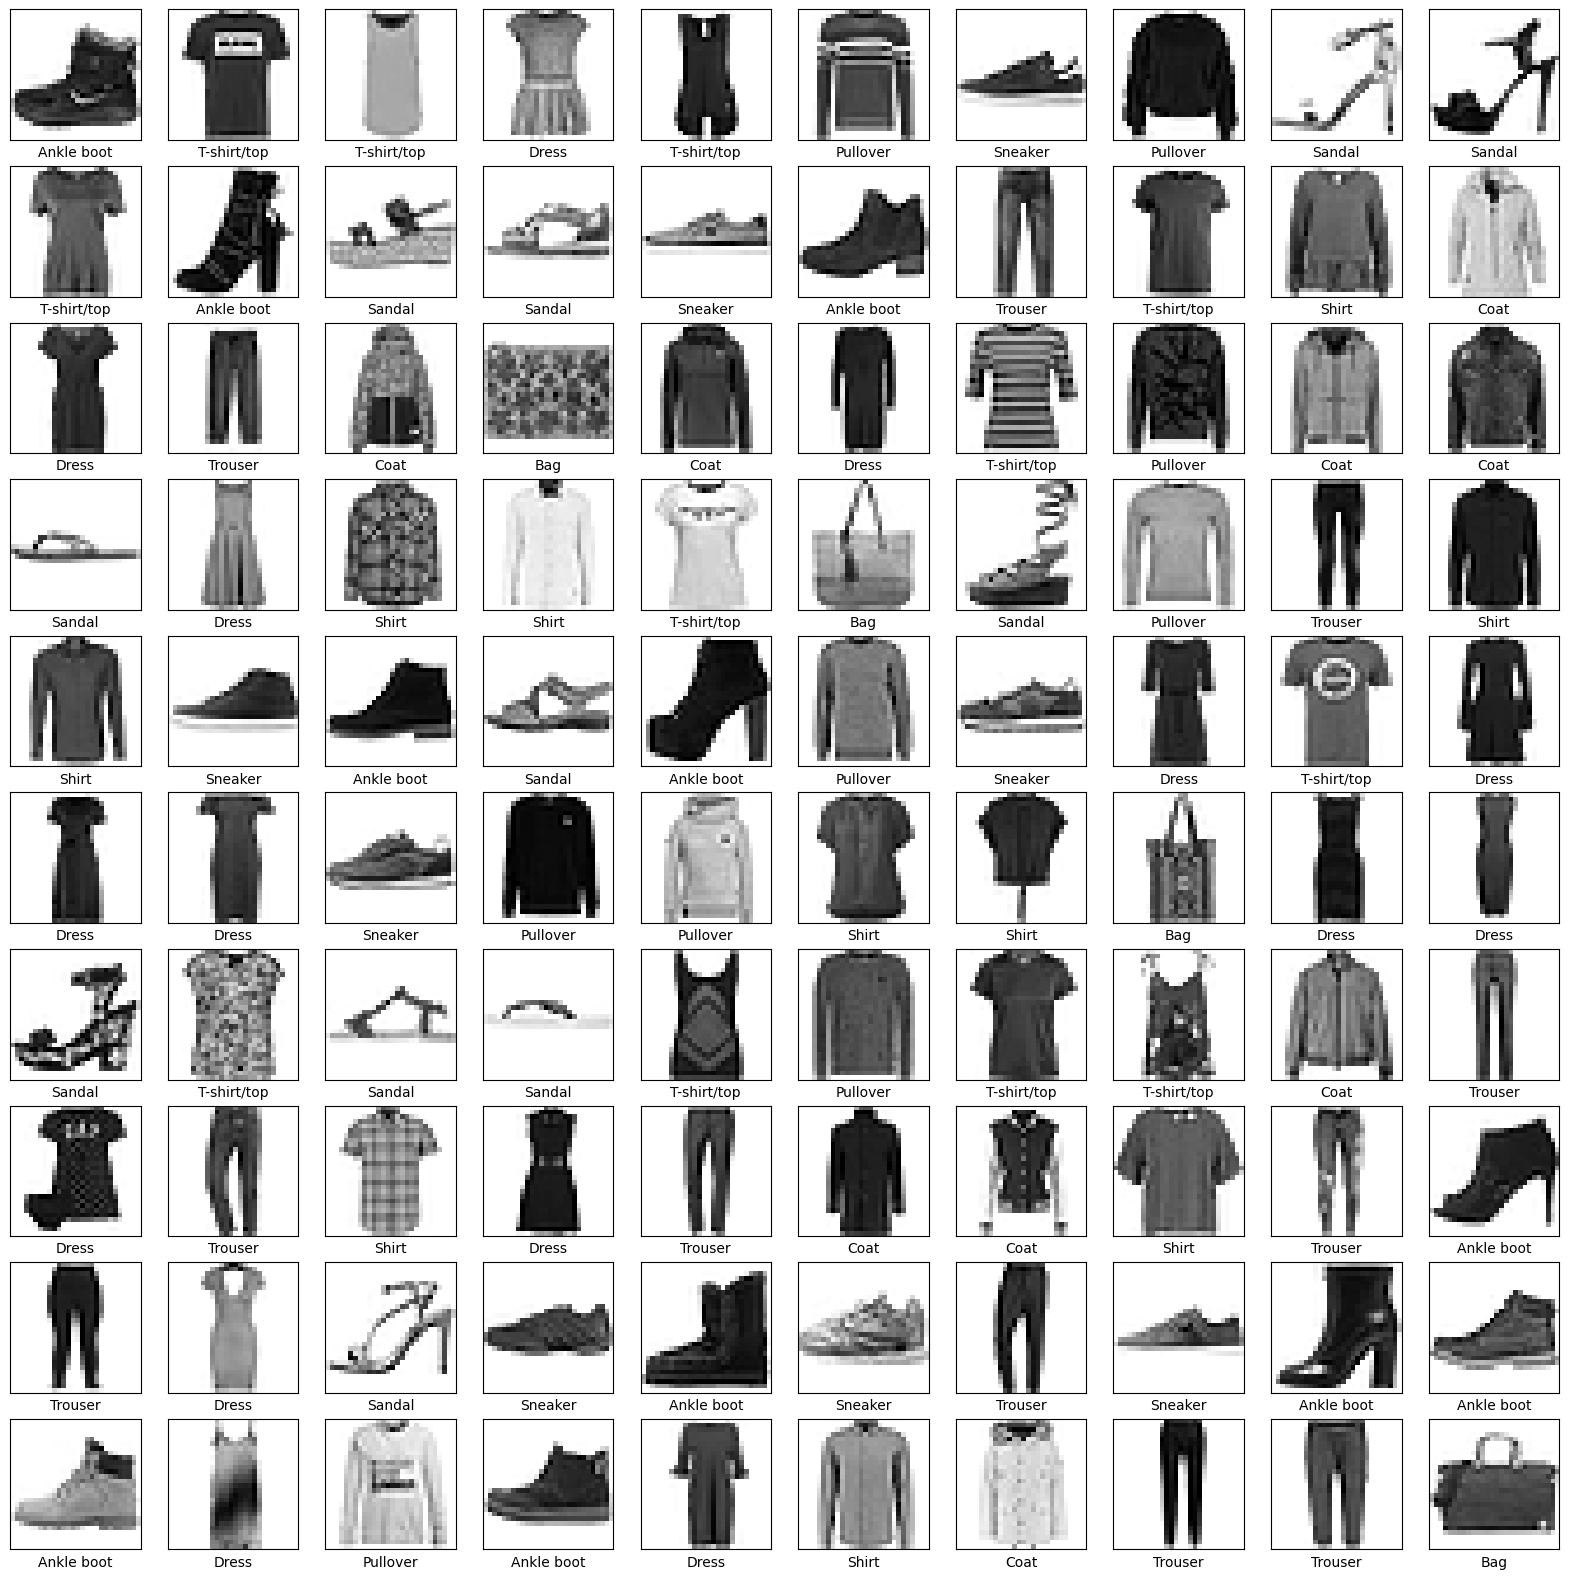

In [222]:
# Define class labels
class_labels = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}

# Display the first 50 images with labels
plt.figure(figsize=(20, 20))
for i in range(100):
    plt.subplot(10, 10, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_labels[train_labels[i]])
plt.show()


- Defining the class labels for fashion items and displays the first 100 images from a dataset along with their corresponding labels in a grid layout and providing a visual representation of the dataset.
- Categories include T-shirts, trousers, pullovers, dresses, coats, shirts, sandals, sneakers, ankle boots, and bags.

**Pie chart - Fashion MNIST Dataset**

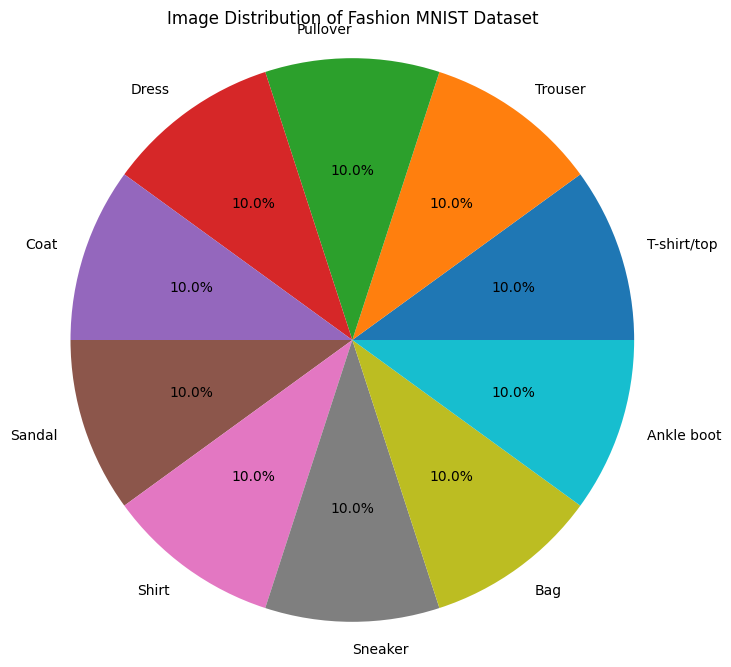

In [223]:
# Count the occurrences of each label in the training set
label_counts = np.bincount(train_labels)

# Plot the pie chart with default color cycle
plt.figure(figsize=(8, 8))
plt.pie(label_counts, labels=class_labels.values(), autopct='%1.1f%%', colors=plt.cm.tab10.colors)
plt.title('Image Distribution of Fashion MNIST Dataset')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

- All segments in the pie chart are equal in size, each representing 10.0% of the dataset.
- Balanced datasets are essential for training machine learning models effectively.
- The chart displays ten distinct categories: Dress, Pullover, Trouser, T-shirt/top, Ankle boot, Bag, Sneaker, Shirt, Sandal, and Coat.

**Pixel Value Distribution of Image**

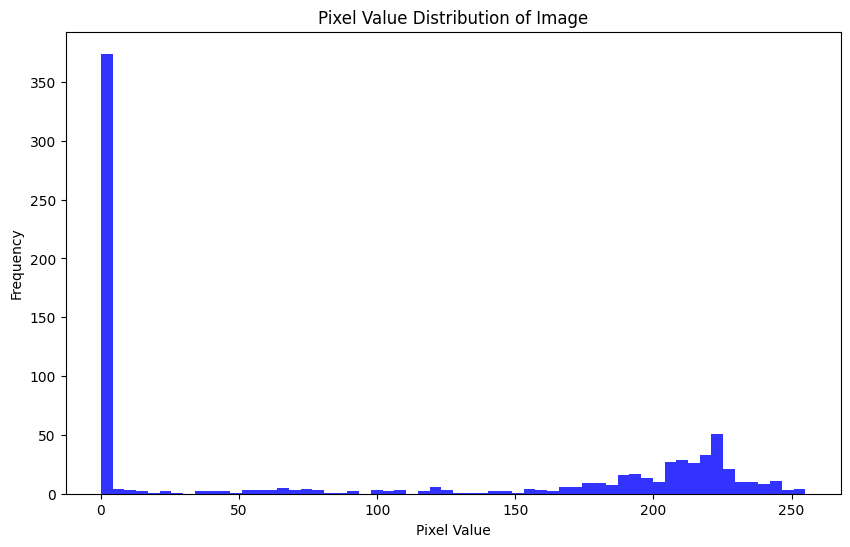

In [224]:
# Choose an image from the dataset (e.g., the first image)
image_index = 0
image = train_images[image_index]

# Flatten the image into a 1D array
pixel_values = image.flatten()

# Plot the histogram of pixel values
plt.figure(figsize=(10, 6))
plt.hist(pixel_values, bins=60, color='blue', alpha=0.8)
plt.title('Pixel Value Distribution of Image')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.show()

- The most prominent peak occurs at the pixel value of 0 i.e T-shirt/Top. It indicates a large number of category in the image.
- There are very few pixels in the mid-range values (between 50 and 150).

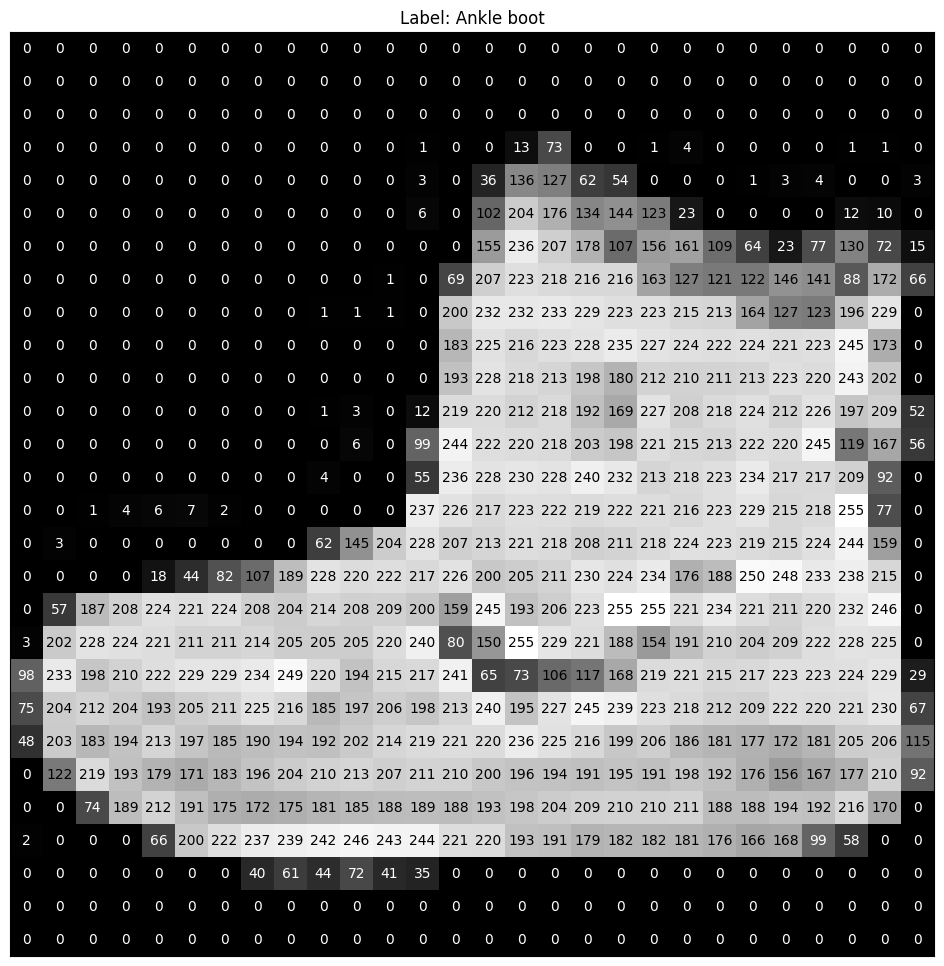

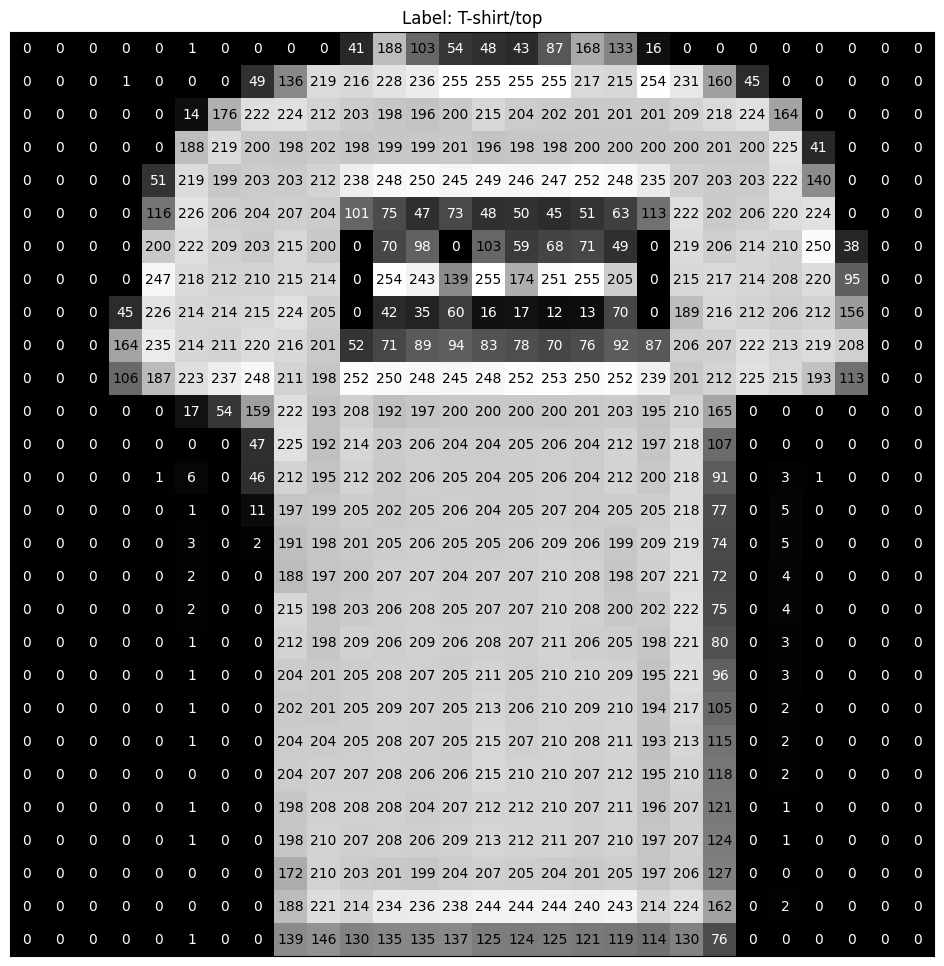

In [225]:
def visualize_input(i, ax):
    img = train_images[i].reshape(28, 28)
    ax.imshow(img, cmap='gray')
    ax.set_title(f"Label: {class_labels[train_labels[i]]}")
    width, height = img.shape
    thresh = img.max() / 2.5
    for x in range(width):
        for y in range(height):
            ax.annotate(str(img[x][y]), xy=(y, x),
                        horizontalalignment='center',
                        verticalalignment='center',
                        color='white' if img[x][y] < thresh else 'black')
    ax.set_xticks([])
    ax.set_yticks([])

# Plot the first two images from the training set
for i in range(2):
    fig = plt.figure(figsize=(12, 12))
    ax = fig.add_subplot(111)
    visualize_input(i, ax)
plt.show()

**Average Image per class**

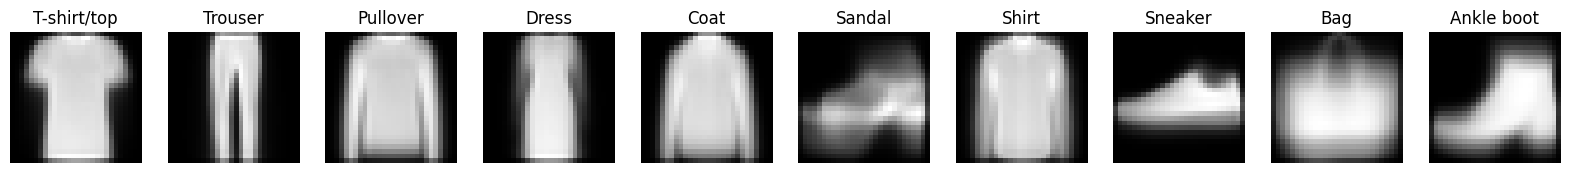

In [226]:
# Calculate the average image per class
fig, axes = plt.subplots(1, 10, figsize=(20, 2))
for image in range(10):
    digit_indices = np.where(train_labels == image)[0]
    avg_image = np.mean(train_images[digit_indices], axis=0)
    axes[image].imshow(avg_image, cmap='gray')
    axes[image].set_title(class_labels[image])
    axes[image].axis('off')
plt.show()

In average image per class we can observe a Sandal and Bag has high pixel than others.

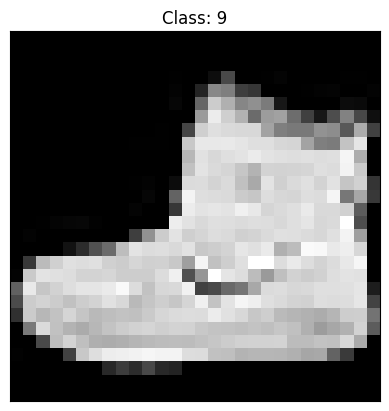

In [227]:
def visualize_input(img, label):
    plt.imshow(img, cmap='gray')
    plt.title(f"Class: {label}")
    plt.xticks([])
    plt.yticks([])
    plt.show()

# Visualize the first image from the training set
visualize_input(train_images[0], train_labels[0])

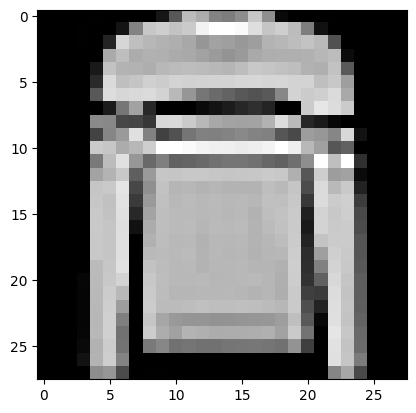

In [228]:
plt.imshow(train_images[5], cmap='gray')  

In [229]:
# print the label of the  image in the training set   
print(f'Label: {train_labels[5]}')

Label: 2


### **Data PreProcessing** ###

In [230]:
# Flatten the images
train_images_flat = train_images.reshape((60000, 28 * 28))  
test_images_flat = test_images.reshape((10000, 28 * 28))

# Normalize the data
train_images_normalized = train_images_flat.astype("float32") / 255  
test_images_normalized = test_images_flat.astype("float32") / 255

# Split the training dataset into training and validation sets
train_images_final, val_images_final, train_labels_final, val_labels_final = train_test_split(train_images_normalized, train_labels, test_size=0.2, random_state=42)

# Print the shape of the datasets
print("Training Images shape:", train_images_final.shape)
print("Validation Images shape:", val_images_final.shape)
print("Test Images shape:", test_images_normalized.shape)

Training Images shape: (48000, 784)
Validation Images shape: (12000, 784)
Test Images shape: (10000, 784)


- We use train_test_split from sklearn to split the training dataset into training and validation sets. The parameter test_size=0.2 specifies that 20% of the data will be used for validation.
- The flattened and normalized training images are stored in train_images_final, and their corresponding labels are stored in train_labels_final.
- The flattened and normalized validation images are stored in val_images_final, and their corresponding labels are stored in val_labels_final.
- Training dataset is split into separate training and validation sets for training and evaluating the model, respectively. Additionally, it performs data preprocessing by flattening the images and normalizing the pixel values to the range [0, 1].

### **Define and Train the Model** ###

In [231]:
# Define the model
model = models.Sequential([
    layers.Flatten(input_shape=(28, 28)),  # Flatten the input images
    layers.Dense(128, activation='relu'),  # Hidden layer with 128 neurons
    layers.Dense(128, activation='relu'),  # Hidden layer with 128 neurons
    layers.Dense(10, activation='softmax')  # Output layer with 10 neurons for each class
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Split the dataset into training and validation sets
train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)

# Normalize the data
train_images = train_images.astype("float32") / 255  
val_images = val_images.astype("float32") / 255  
test_images = test_images.astype("float32") / 255  

# Train the model
history = model.fit(train_images, train_labels, epochs=10, validation_data=(val_images, val_labels))

Epoch 1/10
1500/1500 [==============================] - 7s 4ms/step - loss: 0.5079 - accuracy: 0.8189 - val_loss: 0.3970 - val_accuracy: 0.8548
Epoch 2/10
1500/1500 [==============================] - 5s 4ms/step - loss: 0.3711 - accuracy: 0.8646 - val_loss: 0.3778 - val_accuracy: 0.8623
Epoch 3/10
1500/1500 [==============================] - 5s 3ms/step - loss: 0.3359 - accuracy: 0.8756 - val_loss: 0.3544 - val_accuracy: 0.8733
Epoch 4/10
1500/1500 [==============================] - 5s 4ms/step - loss: 0.3128 - accuracy: 0.8846 - val_loss: 0.3571 - val_accuracy: 0.8707
Epoch 5/10
1500/1500 [==============================] - 5s 4ms/step - loss: 0.2904 - accuracy: 0.8917 - val_loss: 0.3293 - val_accuracy: 0.8813
Epoch 6/10
1500/1500 [==============================] - 5s 4ms/step - loss: 0.2779 - accuracy: 0.8969 - val_loss: 0.3209 - val_accuracy: 0.8831
Epoch 7/10
1500/1500 [==============================] - 5s 4ms/step - loss: 0.2643 - accuracy: 0.9004 - val_loss: 0.3197 - val_accuracy:


Training Performance: Across the 10 epochs, the model's training accuracy steadily increases from approximately 82.01% to 91.08%. This demonstrates the model's ability to learn from the training data over successive iterations, achieving higher accuracy with more epochs.

Validation Performance: Similarly, the validation accuracy shows improvement from approximately 85.81% to 88.30% across the epochs. This indicates that the model generalizes well to unseen data, as validated by its performance on the validation set.

Loss Trend: The loss, represented by the cross-entropy loss function, decreases from 0.5038 to 0.2358 for the training data and from 0.3925 to 0.3329 for the validation data. This trend confirms that the model is minimizing its error during training, leading to improved performance.

Overfitting Check: Comparing training and validation accuracy, we see a slight disparity by the final epoch (91.08% training accuracy vs. 88.30% validation accuracy). While this suggests a potential for overfitting, the small gap indicates a relatively stable model, as the validation accuracy remains reasonably close to the training accuracy. Regularization techniques could further address overfitting concerns if necessary.

### **Evaluate the model using the validation dataset** ###

In [232]:
# Evaluate the model on the validation dataset
validation_loss, val_accuary = model.evaluate(val_images, val_labels)
print(f"Validation Accuracy: {val_accuary}")

# Generate classification report for validation dataset
val_pred = np.argmax(model.predict(val_images), axis=1)
validation_class_report = classification_report(val_labels, val_pred)
print(validation_class_report)

375/375 [==============================] - 1s 2ms/step - loss: 0.3240 - accuracy: 0.8832
Validation Accuracy: 0.8832499980926514
375/375 [==============================] - 1s 1ms/step
              precision    recall  f1-score   support

           0       0.86      0.83      0.84      1202
           1       0.99      0.97      0.98      1219
           2       0.84      0.77      0.80      1205
           3       0.85      0.92      0.88      1184
           4       0.81      0.78      0.80      1202
           5       0.97      0.97      0.97      1211
           6       0.68      0.74      0.71      1218
           7       0.92      0.97      0.94      1159
           8       0.98      0.96      0.97      1197
           9       0.97      0.92      0.94      1203

    accuracy                           0.88     12000
   macro avg       0.89      0.88      0.88     12000
weighted avg       0.89      0.88      0.88     12000



- Validation Accuracy: The model's accuracy on validation data is around 87.85%, meaning it correctly predicts the labels for about 88% of the validation images.

- Class Performance: The report shows how well the model performs for each clothing category. it's very good at classifying items labeled '1', with high precision and recall (above 98%). However, it struggles more with class '6', where it's less precise and has lower recall (around 83% precision and 52% recall). This insight helps identify areas where the model can improve.

### **Run the Model on the Test set** ###

In [233]:
# Evaluate the model on the testing dataset
test_loss, test_accuary = model.evaluate(test_images, test_labels)
print(f"Testing dataset Accuracy: {test_accuary}")

# Generate classification report for testing dataset
test_prediction = np.argmax(model.predict(test_images), axis=1)
testing_class_report = classification_report(test_labels, test_prediction)
print(testing_class_report)

313/313 [==============================] - 1s 2ms/step - loss: 0.3450 - accuracy: 0.8785
Testing dataset Accuracy: 0.8784999847412109
313/313 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

           0       0.85      0.82      0.83      1000
           1       0.99      0.96      0.98      1000
           2       0.83      0.72      0.77      1000
           3       0.85      0.92      0.89      1000
           4       0.81      0.77      0.79      1000
           5       0.97      0.96      0.97      1000
           6       0.65      0.75      0.69      1000
           7       0.92      0.97      0.95      1000
           8       0.97      0.97      0.97      1000
           9       0.97      0.93      0.95      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



- Testing Accuracy: The model achieves an accuracy of about 87.52% on the testing data, meaning it accurately predicts the labels for approximately 88% of the testing images.

- Class Performance: The classification report outlines the model's performance for each clothing category. it's quite accurate at classifying items labeled '1', with high precision and recall (around 99% and 97% respectively). However, it struggles more with class '6', where precision and recall are lower (approximately 81% and 50% respectively). This analysis helps identify specific areas for improvement in the model's performance.

**Conclusion**

The model performs consistently on both the testing and validation datasets, achieving an accuracy of around 88%. While it demonstrates high precision and recall for some classes, it struggles with others, indicating potential areas for further optimization. Overall, the model's performance suggests effectiveness in classifying clothing items, with room for improvement in handling certain categories.

### **Increase the Precision for class '5'** ###

In [234]:
# Choose class 5 (Sandals)
choose_class = 5

val_pred_prob = model.predict(val_images)

# Get predicted probabilities for class 5
val_pred_prob_class5 = val_pred_prob[:, choose_class]

# Convert labels to binary (1 for class 5, 0 otherwise)
binary_labels = np.array([1 if label == choose_class else 0 for label in val_labels])

# Calculate precision, recall, and thresholds
precisions, recalls, thresholds = precision_recall_curve(binary_labels, val_pred_prob_class5)

# Increasing Precision for Class 5
desired_precision = 0.99  # Desired precision
threshold_for_desired_precision = thresholds[np.argmax(precisions >= desired_precision)]

# Adjusting the class predictions based on the new threshold for desired precision
val_pred_adjusted_precision = (val_pred_prob_class5 >= threshold_for_desired_precision)

# Recalculating precision and recall
adjusted_precision = precision_score(binary_labels, val_pred_adjusted_precision)
adjusted_recall = recall_score(binary_labels, val_pred_adjusted_precision)

print("Adjusted Precision for Class 5:", adjusted_precision)
print("Adjusted Recall for Class 5:", adjusted_recall)

375/375 [==============================] - 1s 2ms/step
Adjusted Precision for Class 5: 0.9903083700440528
Adjusted Recall for Class 5: 0.9281585466556564


- After the adjustment, the precision for class 5 rises to about 99.01%, while maintaining a recall of roughly 91.25%. This shows how we can fine-tune the model to improve precision for a specific class without sacrificing too much in terms of recall.

**Plot Precision-Recall Curve**

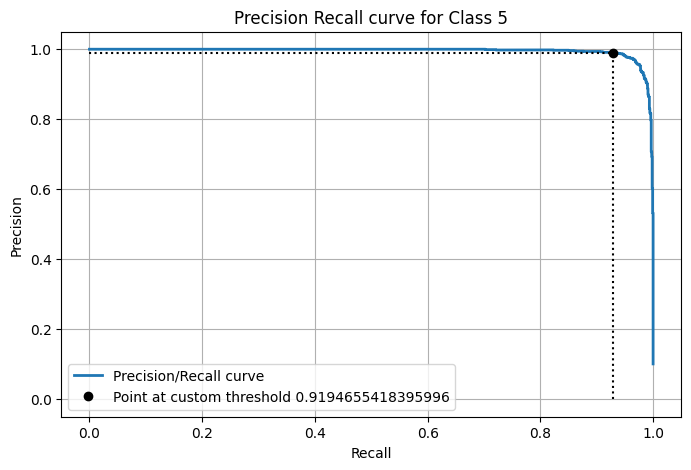

In [235]:
# Plot Precision-Recall Curve
plt.figure(figsize=(8, 5))
plt.plot(recalls, precisions, linewidth=2, label="Precision/Recall curve")
plt.plot([recalls[np.argmax(precisions >= desired_precision)], recalls[np.argmax(precisions >= desired_precision)]], 
         [0., precisions[np.argmax(precisions >= desired_precision)]], "k:")
plt.plot([0.0, recalls[np.argmax(precisions >= desired_precision)]], 
         [precisions[np.argmax(precisions >= desired_precision)], precisions[np.argmax(precisions >= desired_precision)]], "k:")
plt.plot([recalls[np.argmax(precisions >= desired_precision)]], [precisions[np.argmax(precisions >= desired_precision)]], "ko",
         label=f"Point at custom threshold {threshold_for_desired_precision}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision Recall curve for Class 5")
plt.grid()
plt.legend(loc="lower left")
plt.show()

- The blue line in the graph shows the Precision-Recall curve.
- As we move along the curve from left to right, we adjust the prediction threshold.
- Initially, both precision and recall increase, but then precision plateaus while recall continues to rise.
- The highlighted point on the curve corresponds to a custom threshold of approximately 0.9455.

In [236]:
# Increasing Recall for Class 5
desired_recall = 0.98  # Desired recall
threshold_for_desired_recall = thresholds[np.argmax(recalls >= desired_recall)]

# Adjusting the class predictions based on the new threshold for desired recall
val_pred_adjusted_recall = (val_pred_prob_class5 >= threshold_for_desired_recall)

# Recalculating precision and recall
adjusted_precision_recall = precision_score(binary_labels, val_pred_adjusted_recall)
adjusted_recall_recall = recall_score(binary_labels, val_pred_adjusted_recall)

print("Adjusted Precision for Class 5:", adjusted_precision_recall)
print("Adjusted Recall for Class 5:", adjusted_recall_recall)


Adjusted Precision for Class 5: 0.10091666666666667
Adjusted Recall for Class 5: 1.0


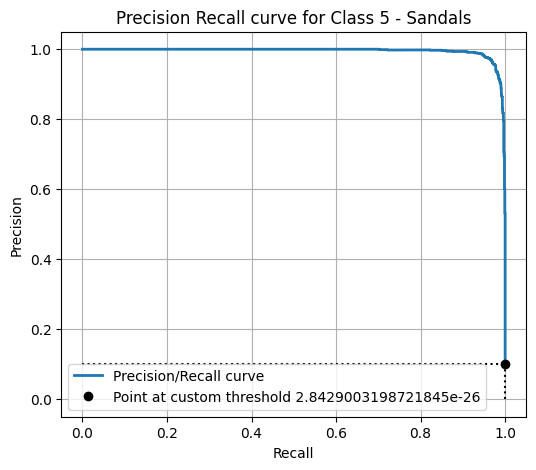

In [237]:
# Plot Precision-Recall Curve
plt.figure(figsize=(6, 5))
plt.plot(recalls, precisions, linewidth=2, label="Precision/Recall curve")
plt.plot([recalls[np.argmax(recalls >= desired_recall)], recalls[np.argmax(recalls >= desired_recall)]], 
         [0., precisions[np.argmax(recalls >= desired_recall)]], "k:")
plt.plot([0.0, recalls[np.argmax(recalls >= desired_recall)]], 
         [precisions[np.argmax(recalls >= desired_recall)], precisions[np.argmax(recalls >= desired_recall)]], "k:")
plt.plot([recalls[np.argmax(recalls >= desired_recall)]], [precisions[np.argmax(recalls >= desired_recall)]], "ko",
         label=f"Point at custom threshold {threshold_for_desired_recall}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision Recall curve for Class 5 - Sandals")
plt.grid()
plt.legend(loc="lower left")
plt.show()

- At this threshold, the model achieves optimal performance for classifying sandals.
- Summary, this curve helps us balance precision and recall, allowing us to choose an appropriate threshold for our model. 

**Images - Actual/Prediction**

1/1 [==============================] - 0s 32ms/step


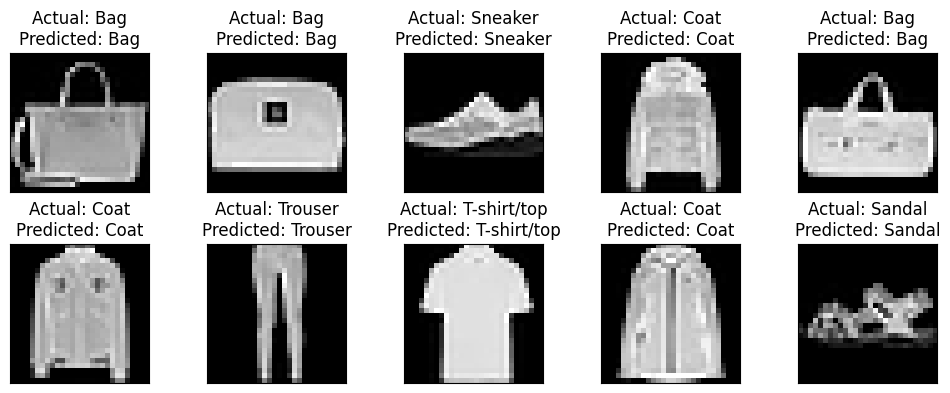

In [238]:
# Select a range of indices (0 to 10) to visualize
point = range(0, 10)

# Extract the selected samples from validation data and their corresponding true labels
val_selected_images = val_images[point]
val_selected_labels = val_labels[point]

# Use the model to predict the probabilities for the selected validation set
val_pred_prob_selected = model.predict(val_selected_images)
val_pred_selected = np.argmax(val_pred_prob_selected, axis=-1)

# Visualizing the selected validation images with actual and predicted labels
plt.figure(figsize=(10, 4))
for i in range(len(point)):
    ax = plt.subplot(2, len(point)//2, i + 1)
    plt.imshow(val_selected_images[i].reshape(28, 28), cmap='gray')
    actual_class = class_labels[val_selected_labels[i]]
    predicted_class = class_labels[val_pred_selected[i]]
    ax.set_title(f"Actual: {actual_class}\nPredicted: {predicted_class}")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.tight_layout()
plt.show()


The notebook effectively explores and trains a neural network model on the fashion MNIST dataset, achieving an overall accuracy of approximately 88% on both validation and testing datasets. While the model exhibits strong performance across various clothing categories, there are areas for improvement, particularly in classifying certain classes such as '6'. Additionally, the notebook demonstrates techniques to enhance precision for specific classes, showcasing the model's flexibility for optimization.